# Note that Jeremy made some refactoring changes to 9b after I made this copy

# Let's kill off `Runner`

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_09 import *

## Imagenette data

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [5]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [6]:
nfs = [32]*4

Having a Runner is great but not essential when the `Learner` already has everything needed in its state. We implement everything inside it directly instead of building a second object.

In [7]:
#export
def param_getter(m): return m.parameters()

class Learner():
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2, splitter=param_getter,
                 cbs=None, cb_funcs=None):
#         instead of having a separate learner and runner, take runner class, make it learner class and add
#         items we were storing in learner to here
        self.model,self.data,self.loss_func,self.opt_func,self.lr,self.splitter = model,data,loss_func,opt_func,lr,splitter
        self.in_train,self.logger,self.opt = False,print,None
        
        # NB: Things marked "NEW" are covered in lesson 12
        # NEW: avoid need for set_runner
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)
            
    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')

    def fit(self, epochs, cbs=None, reset_opt=False):
        # NEW: pass callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # NEW: create optimizer on fit(), optionally replacing existing
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
            
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                self.do_begin_epoch(epoch)
                if not self('begin_epoch'): self.all_batches()

                with torch.no_grad(): 
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)

    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [8]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        #We use the logger function of the `Learner` here, it can be customized to write in a file or in a progress bar
        self.logger(self.train_stats)
        self.logger(self.valid_stats) 

In [9]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [10]:
#export
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [11]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [12]:
%time learn.fit(1)

train: [1.8140323260818985, tensor(0.3650, device='cuda:0')]
valid: [1.6679393310546875, tensor(0.4480, device='cuda:0')]
CPU times: user 4.85 s, sys: 2.44 s, total: 7.3 s
Wall time: 7.7 s


## Check everything works

Let's check our previous callbacks still work.

In [13]:
cbfs += [Recorder]

In [14]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [15]:
phases = combine_scheds([0.3, 0.7], cos_1cycle_anneal(0.2, 0.6, 0.2))
sched = ParamScheduler('lr', phases)

In [16]:
learn.fit(1, sched)

train: [1.8383945839634714, tensor(0.3620, device='cuda:0')]
valid: [1.461771484375, tensor(0.5200, device='cuda:0')]


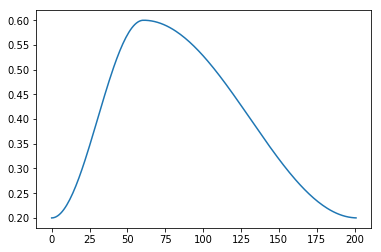

In [17]:
learn.recorder.plot_lr()

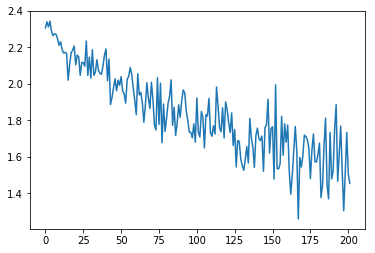

In [18]:
learn.recorder.plot_loss()

## Export

In [ ]:
!./notebook2script.py 09b_learner.ipynb

Converted 09b_learner.ipynb to exp/nb_09b.py
